### Figure sugestions 

1. For which purposes is gas used in EU today (percentage of electricity generation, heating, industry ...) + For which purposes we expect to use gas in 2030 (transition path without/with gas limitations)

2. When do we expect new technologies substituting gas ( i.e, methanation by Sabatier reaction and biogas upgrade into biomethane) to appear in the model for the ambitious (1.5C budget) and less ambitious (2C budget)?. Do these transformations appear earlier when limiting the use of gas?

3. How does the heating supply evolve with/without gas? What are the required ramping rates for the heat pumps?

4. What is the total cost evolution for the system with/without a gas limit? How more expensive is the transition because of the gas limit? Is the cumulative cost 1% or 10% more expensive?

5. Typically, gas covers the winter peaks (for electricity generation and heating demand), which technology is taking care of the peaks under a limited-gas scenario?

- Gas consumption vs time step. A dashed line indicates the cap. Two lines are drawn. One for a baseline with no cap and another with the cap. On the same figure (maybe in another panel) we show the shadow price for gas. If the cap is binding, the price should be higher than our regular gas price.

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa
import warnings
import yaml
warnings.filterwarnings("ignore")
import pickle
import os

from matplotlib import rc
rc('text', usetex=False)

In [4]:
with open('./tech_colors.yaml') as file:
    tech_colors = yaml.safe_load(file)['tech_colors']
tech_colors['ambient heat'] = tech_colors['heat pumps']

In [5]:
override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus3"] = ["string",np.nan,np.nan,"3rd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus4"] = ["string",np.nan,np.nan,"4th bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency3"] = ["static or series","per unit",1.,"3rd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency4"] = ["static or series","per unit",1.,"4th bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]
override_component_attrs["Link"].loc["p3"] = ["series","MW",0.,"3rd bus output","Output"]
override_component_attrs["Link"].loc["p4"] = ["series","MW",0.,"4th bus output","Output"]

In [6]:
fs = 18
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs

In [7]:
def import_df(path,scenario,addopts='',n_index=3,n_header=4):
    df = pd.read_csv(path,index_col=list(range(n_index)),header=list(range(n_header)))
    df = df.droplevel(0,axis=1)
    df = df.droplevel(0,axis=1)
    df = df.loc[:,['3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0','3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0','3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0-gasconstrained' + addopts,'3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0-gasconstrained' + addopts]]
    df.rename(columns={'3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0':f'1.5_base','3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0':f'2_base',
                        '3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0-gasconstrained' + addopts:'1.5_no_gas','3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0-gasconstrained' + addopts:'2_no_gas'},level=0,inplace=True)
    return df


In [8]:
path = '../results/PyPSA-Eur-Sec-0.6.0/3H_oil_lignite_nonextendable/'
#path = '../results/PyPSA-Eur-Sec-0.6.0/3H_LNG_70eur/'

In [9]:
lngopt = ''

In [10]:
#lngopt = '-LNG'

In [11]:
supply_energy = import_df(path + 'csvs/supply_energy.csv','no_gas',addopts=lngopt)
nodal_capacities = import_df(path + 'csvs/nodal_capacities.csv','no_gas',addopts=lngopt)
costs = import_df(path + 'csvs/costs.csv','no_gas',addopts=lngopt)
metrics = import_df(path + 'csvs/metrics.csv','no_gas',addopts=lngopt,n_index=1)
prices = import_df(path + 'csvs/price_statistics.csv','no_gas',addopts=lngopt,n_index=1)

In [12]:
metrics

opt                     1.5_base                                            \
planning_horizon            2020          2025          2030          2035   
line_volume         1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_limit   1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_AC      1.333428e+08  1.333428e+08  1.333428e+08  1.333428e+08   
line_volume_DC      1.291735e+07  1.291735e+07  1.291735e+07  1.291735e+07   
line_volume_shadow           NaN           NaN           NaN           NaN   
co2_shadow          1.794524e+01  8.541300e+01  4.679332e+02  4.341706e+02   
total costs         7.488655e+11  7.443559e+11  9.679052e+11  1.067203e+12   

opt                                                                 2_base  \
planning_horizon            2040          2045          2050          2020   
line_volume         1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_limit   1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_AC      1.333428e+08  1.333428e+08  1.333428e+08  1.333428e+08   
line_volume_DC      1.291735e+07  1.291735e+07  1.291735e+07  1.291735e+07   
line_volume_shadow           NaN           NaN           NaN           NaN   
co2_shadow          3.390530e+02  2.394751e+02  2.107262e+02  1.794524e+01   
total costs         1.030612e+12  9.781264e+11  9.173760e+11  7.488655e+11   

opt                                             ...    1.5_no_gas  \
planning_horizon            2025          2030  ...          2040   
line_volume         1.462601e+08  1.462601e+08  ...  1.462601e+08   
line_volume_limit   1.462601e+08  1.462601e+08  ...  1.462601e+08   
line_volume_AC      1.333428e+08  1.333428e+08  ...  1.333428e+08   
line_volume_DC      1.291735e+07  1.291735e+07  ...  1.291735e+07   
line_volume_shadow           NaN           NaN  ...           NaN   
co2_shadow          1.792732e+01  2.684606e+01  ...  3.428696e+02   
total costs         6.969746e+11  6.539324e+11  ...  1.033645e+12   

opt                                                 2_no_gas                \
planning_horizon            2045          2050          2020          2025   
line_volume         1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_limit   1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_AC      1.333428e+08  1.333428e+08  1.333428e+08  1.333428e+08   
line_volume_DC      1.291735e+07  1.291735e+07  1.291735e+07  1.291735e+07   
line_volume_shadow           NaN           NaN           NaN           NaN   
co2_shadow          2.394751e+02  2.184875e+02  2.122636e+01  0.000000e+00   
total costs         9.794880e+11  9.176842e+11  7.537594e+11  7.243293e+11   

opt                                                                         \
planning_horizon            2030          2035          2040          2045   
line_volume         1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_limit   1.462601e+08  1.462601e+08  1.462601e+08  1.462601e+08   
line_volume_AC      1.333428e+08  1.333428e+08  1.333428e+08  1.333428e+08   
line_volume_DC      1.291735e+07  1.291735e+07  1.291735e+07  1.291735e+07   
line_volume_shadow           NaN           NaN           NaN           NaN   
co2_shadow          6.623638e-01  4.269182e+01  5.061738e+01  1.026985e+02   
total costs         6.889249e+11  6.607946e+11  6.486788e+11  6.299445e+11   

opt                               
planning_horizon            2050  
line_volume         1.462601e+08  
line_volume_limit   1.462601e+08  
line_volume_AC      1.333428e+08  
line_volume_DC      1.291735e+07  
line_volume_shadow           NaN  
co2_shadow          3.449822e+02  
total costs         7.615835e+11  

[7 rows x 28 columns]

### Make gas price df

In [13]:
if lngopt == '-LNG':
    subframeindex1 = [-25,-7]
    subframeindex2 = [-33,-29]
    yearindex = [-6,-2]
else:
    subframeindex1 = [-21,-7]
    subframeindex2 = [-29,-25]
    yearindex = [-6,-2]

In [14]:
p = path + 'postnetworks/'
files = os.listdir(p)
gas_prices = {}
for f in files:
    if f[-1] == 'p' and f[subframeindex1[0]:subframeindex1[1]] == 'gasconstrained' + lngopt:
        year = int(f[yearindex[0]:yearindex[1]])
        gas_price = float(pickle.load( open(p+f, "rb" ))[0]['Generator']['df']['gas_limit'].values)
        if f[subframeindex2[0]:subframeindex2[1]] == '73.9':
            scenario = '2'
        elif f[subframeindex2[0]:subframeindex2[1]] == '25.7':
            scenario = '1.5'
        
        gas_prices[scenario+'_'+str(year)] = (year,scenario,gas_price)
        
gas_prices = pd.DataFrame(data=gas_prices.values(),columns=['year','scenario','gas_price'])

In [15]:
def rename_techs(label):

    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral "
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch"
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        # "H2 Electrolysis": "hydrogen storage",
        # "H2 Fuel Cell": "hydrogen storage",
        # "H2 pipeline": "hydrogen storage",
        "battery": "battery storage",
        # "CC": "CC"
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
        'uranium':'nuclear'
    }

    for ptr in prefix_to_remove:
        if label[:len(ptr)] == ptr:
            label = label[len(ptr):]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old,new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old,new in rename.items():
        if old == label:
            label = new
    return label

## Figure - Capacity plots

### Overall generator capacities

In [16]:
def gen_df_for_cap_plot(lngopt=''):

        df_ren = nodal_capacities.loc[('generators',slice(None),slice(None))].groupby(level=2).sum()
        renewable_techs = ['offwind',
                'offwind-ac',
                'offwind-dc',
                'onwind',
                'solar',
                'solar rooftop',
                'residential rural solar thermal',
                'residential urban decentral solar thermal',
                'services rural solar thermal',
                'services urban decentral solar thermal',
                'urban central solar thermal',
                'ror',
                ]
        
        if lngopt == '-LNG':
            renewable_techs += ['LNG'] # Not renewable, but might be relavent to include in this figure
        
        df_ren = df_ren.loc[renewable_techs]
        df_ren = df_ren.groupby([rename_techs(t)for t in renewable_techs]).sum() * 1e-3
        df_ren.rename(index={'offshore wind':'wind',
                        'offshore wind (AC)':'wind',
                        'offshore wind (DC)':'wind',
                        'onshore wind':'wind',
                        'solar PV':'solar',
                        'solar rooftop':'solar',
                        'solar thermal':'solar',
                        'LNG':'LNG'
                        },inplace=True)
        df_ren = df_ren.groupby(level=0).sum()

        df_ren.loc['hydroelectricity'] = nodal_capacities.loc[('storage_units',slice(None),'hydro')].sum()*1e-3 + df_ren.loc['hydroelectricity']

        fossil_generetor_techs = ['nuclear',  ]
        df_fosil = nodal_capacities.loc[('links',slice(None),fossil_generetor_techs)]
        df_fosil= df_fosil.groupby(level=2).sum() * 1e-3

        df = pd.concat((df_ren,df_fosil))
        return df

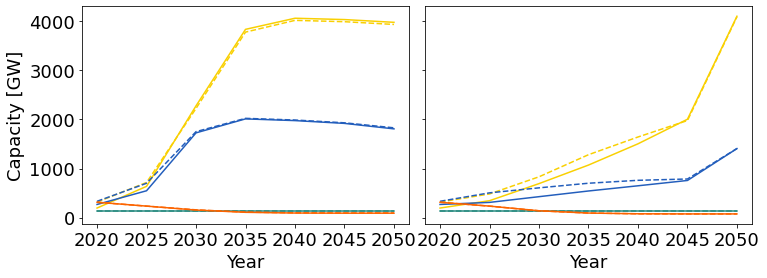

In [17]:
df = gen_df_for_cap_plot()

fig,axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey='row')
axes = axes.flatten()

for i,scen in enumerate(['1.5','2']):
    df_i = df.loc[:,[f'{scen}_base',f'{scen}_no_gas']].T.unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.plot(color=[tech_colors[t] for t in list(df_i.columns.get_level_values(0))],
                style=['-','--']*10,
                ax=axes[i],
                legend=False)
    axes[i].set_ylabel('Capacity [GW]')
    axes[i].set_xlabel('Year')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(7))
    #if i >=2:
    #    axes[i].set_ylim(0,500)
    #else :
    #    axes[i].set_ylim(500,3000)
#
fig.subplots_adjust(wspace=0.05)
#plt.tight_layout()


### Renewable capacities

In [18]:
df = nodal_capacities.loc[('generators',slice(None),slice(None))].groupby(level=2).sum()
renewable_techs = ['offwind',
        'offwind-ac',
        'offwind-dc',
        'onwind',
        'solar',
        'solar rooftop',
        'residential rural solar thermal',
        'residential urban decentral solar thermal',
        'services rural solar thermal',
        'services urban decentral solar thermal',
        'urban central solar thermal',
        'ror']
df = df.loc[renewable_techs]
df = df.groupby([rename_techs(t)for t in renewable_techs]).sum() * 1e-3
df.rename(index={'offshore wind':'offshore wind','offshore wind (AC)':'offshore wind','offshore wind (DC)':'offshore wind'},inplace=True)
df = df.groupby(level=0).sum()
df  = df.iloc[::-1]

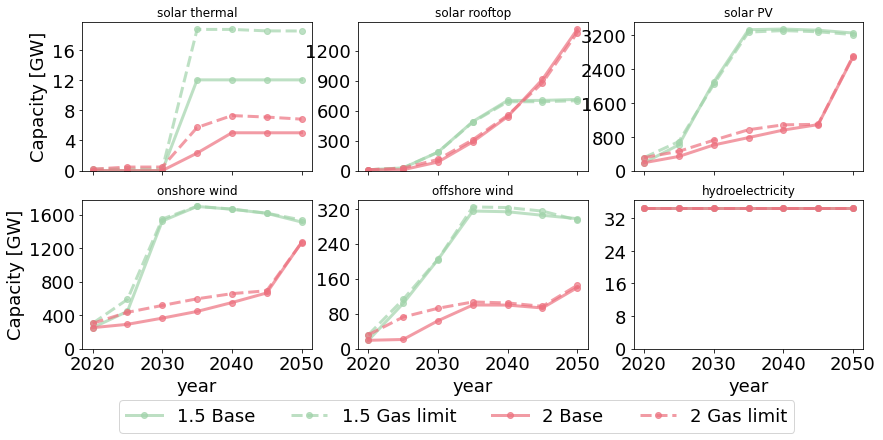

In [19]:
fig,axes = plt.subplots(2,3,figsize=(14,6),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(rename_techs(tech))
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,end)
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0.7, -0.35),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/renewable_capacites_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',bbox_inches='tight')


# Growth rate plot

In [20]:
df_ren = nodal_capacities.loc[('generators',slice(None),slice(None))].groupby(level=2).sum()
renewable_techs = ['offwind',
        'offwind-ac',
        'offwind-dc',
        'onwind',
        'solar',
        'solar rooftop',
        'residential rural solar thermal',
        'residential urban decentral solar thermal',
        'services rural solar thermal',
        'services urban decentral solar thermal',
        'urban central solar thermal',
        'ror']
df_ren = df_ren.loc[renewable_techs]
df_ren = df_ren.groupby([rename_techs(t)for t in renewable_techs]).sum() * 1e-3

df_ren.rename(index={'offshore wind':'offshore wind','offshore wind (AC)':'offshore wind','offshore wind (DC)':'offshore wind'},inplace=True)
df_ren = df_ren.groupby(level=0).sum()
df_ren  = df_ren.iloc[::-1]

In [21]:
heating_techs = ['residential rural biomass boiler', 
                'residential rural gas boiler',
                'residential rural ground heat pump',
                'residential rural resistive heater',
                'residential rural water tanks charger',
                'residential rural water tanks discharger',
                'residential urban decentral air heat pump',
                'residential urban decentral gas boiler',
                'residential urban decentral resistive heater',
                'services rural gas boiler', 
                'services rural ground heat pump',
                'services rural resistive heater', 
                'services rural water tanks charger',
                'services rural water tanks discharger',
                'services urban decentral air heat pump',
                'services urban decentral gas boiler',
                'services urban decentral resistive heater',
                'residential rural oil boiler',
                'residential urban decentral oil boiler', 
                'services rural oil boiler',
                'services urban decentral oil boiler', 
                'urban central oil boiler',
                            ]
df_heat = nodal_capacities.loc[('links',slice(None),heating_techs)]
df_heat= df_heat.groupby(level=2).sum() * 1e-3

df_heat = df_heat.groupby({'residential rural biomass boiler':'biomass boiler', 
                'residential rural gas boiler':'gas boiler',
                'residential rural ground heat pump':'ground heat pump',
                'residential rural resistive heater':'resistive heater',                
                'residential urban decentral air heat pump':'air heat pump',
                'residential urban decentral gas boiler':'gas boiler',
                'residential urban decentral resistive heater':'resistive heater',
                'services rural gas boiler':'gas boiler', 
                'services rural ground heat pump':'ground heat pump',
                'services rural resistive heater':'resistive heater', 
                'services urban decentral air heat pump':'air heat pump',
                'services urban decentral gas boiler':'gas boiler',
                'services urban decentral resistive heater':'resistive heater',
                'residential rural oil boiler':'oil boiler',
                'residential urban decentral oil boiler':'oil boiler', 
                'services rural oil boiler':'oil boiler',
                'services urban decentral oil boiler':'oil boiler', 
                'urban central oil boiler':'oil boiler'}).sum()

df = pd.concat((df_ren,df_heat))
df

opt                 1.5_base                                        \
planning_horizon        2020        2025         2030         2035   
solar thermal       0.000593    0.000456     0.000521    12.007577   
solar rooftop       8.381192   26.767541   184.607782   489.962863   
solar PV          186.412248  610.104061  2093.887267  3335.671049   
onshore wind      249.016610  443.976764  1523.702576  1697.580860   
offshore wind      18.755930  103.093272   203.673329   314.578418   
hydroelectricity   34.503917   34.503917    34.503917    34.503917   
air heat pump      29.735115   27.914182   107.922414   107.796677   
biomass boiler     18.116960   14.342584    10.568217     6.793854   
gas boiler        884.977520  781.662636   626.432852   471.234342   
ground heat pump    6.379190   14.334900    49.383269    50.009065   
oil boiler        401.135201  327.967543   244.393783   160.820023   
resistive heater  395.335716  351.581762   318.554760   268.119462   

opt                                                            2_base  \
planning_horizon         2040          2045          2050        2020   
solar thermal       12.007404  1.200618e+01  1.200617e+01    0.000612   
solar rooftop      700.991965  7.015800e+02  7.116054e+02    8.381205   
solar PV          3351.066888  3.323300e+03  3.257177e+03  186.412259   
onshore wind      1664.323657  1.615544e+03  1.511676e+03  249.016881   
offshore wind      312.925668  3.048730e+02  2.970853e+02   18.755939   
hydroelectricity    34.503917  3.450392e+01  3.450392e+01   34.503917   
air heat pump      102.736510  9.255067e+01  3.929845e+01   29.735112   
biomass boiler       0.000001  2.098432e-07  1.248617e-07   18.116964   
gas boiler         258.321792  1.627953e+02  1.324485e+02  884.977444   
ground heat pump    55.518603  5.436403e+01  4.860338e+01    6.379172   
oil boiler          18.730984  0.000000e+00  0.000000e+00  401.135201   
resistive heater   318.463602  2.980137e+02  2.948027e+02  395.335857   

opt                                       ...    1.5_no_gas                \
planning_horizon        2025        2030  ...          2040          2045   
solar thermal       0.000638    0.000215  ...  1.868190e+01  1.848884e+01   
solar rooftop       8.939964   86.067098  ...  6.880001e+02  6.885881e+02   
solar PV          335.431188  606.619011  ...  3.313999e+03  3.286233e+03   
onshore wind      289.161859  362.869793  ...  1.666471e+03  1.617692e+03   
offshore wind      20.680683   63.555091  ...  3.225234e+02  3.144707e+02   
hydroelectricity   34.503917   34.503917  ...  3.450392e+01  3.450392e+01   
air heat pump      18.241667   12.532310  ...  9.755841e+01  8.474390e+01   
biomass boiler     14.342603   10.568220  ...  8.789494e-07  6.401263e-08   
gas boiler        805.827552  702.583380  ...  2.460036e+02  1.722379e+02   
ground heat pump    6.019229    7.782137  ...  5.694333e+01  5.108132e+01   
oil boiler        327.967543  244.393783  ...  1.873098e+01  0.000000e+00   
resistive heater  351.869992  337.738599  ...  3.315997e+02  3.092286e+02   

opt                               2_no_gas                          \
planning_horizon          2050        2020        2025        2030   
solar thermal     1.847362e+01    0.193115    0.469774    0.473308   
solar rooftop     6.986966e+02    8.267238   25.162710  111.382085   
solar PV          3.220109e+03  307.979548  456.448748  719.734743   
onshore wind      1.535913e+03  300.985565  432.349940  514.478121   
offshore wind     2.939917e+02   31.447459   72.032332   92.064363   
hydroelectricity  3.450392e+01   34.503917   34.503917   34.503917   
air heat pump     3.619360e+01   42.173719   36.343887   33.679236   
biomass boiler    1.529677e-07   18.116958   14.342604   10.568223   
gas boiler        1.541552e+02  858.143153  744.411473  635.792850   
ground heat pump  4.471806e+01   15.770585   19.109419   20.255234   
oil boiler        0.000000e+00  401.135201  327.967543  244.393783   
resisti

In [22]:
df = df.diff(axis=1)
df.drop('2020',axis=1,level=1,inplace=True)
df = df.groupby({#'solar thermal':'solar',
                 'solar rooftop':'solar rooftop',
                 'solar PV':'solar utility',
                 'onshore wind':'onshore wind',
                 'offshore wind':'offshore wind',
                 'air heat pump':'air heat pump',
                 'ground heat pump':'ground heat pump'}).sum()
df = df/5 #Divide by 5 year time step

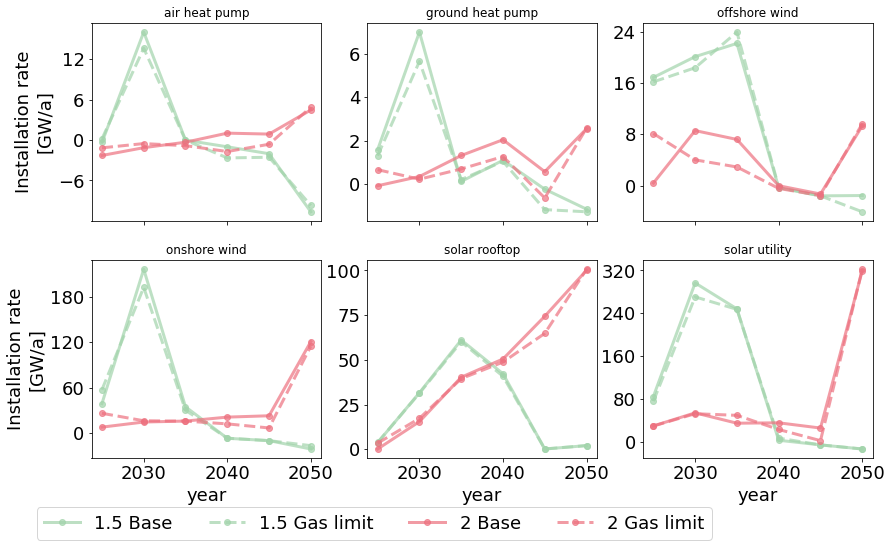

In [23]:
fig,axes = plt.subplots(2,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    #axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Installation rate\n[GW/a]')
axes[3].set_ylabel('Installation rate\n[GW/a]')

#axes[3].set_ylabel('Capacity [GW]')
#axes[6].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0.3, -0.25),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/growth_rates.pdf',bbox_inches='tight')

### Generator capacities

In [21]:
fossil_generetor_techs = ['CCGT',
                            'OCGT',
                            'coal',
                            #'coal CC',
                            'lignite',
                            'oil',
                            'nuclear',
                            'urban central gas CHP',
                            #'urban central gas CHP CC',
                            'urban central solid biomass CHP',
                            'urban central solid biomass CHP CC'
                            ]
df = nodal_capacities.loc[('links',slice(None),fossil_generetor_techs)]

df= df.groupby(level=2).sum() * 1e-3
#df = df.groupby([rename_techs(t)for t in df.index]).sum() * 1e-3

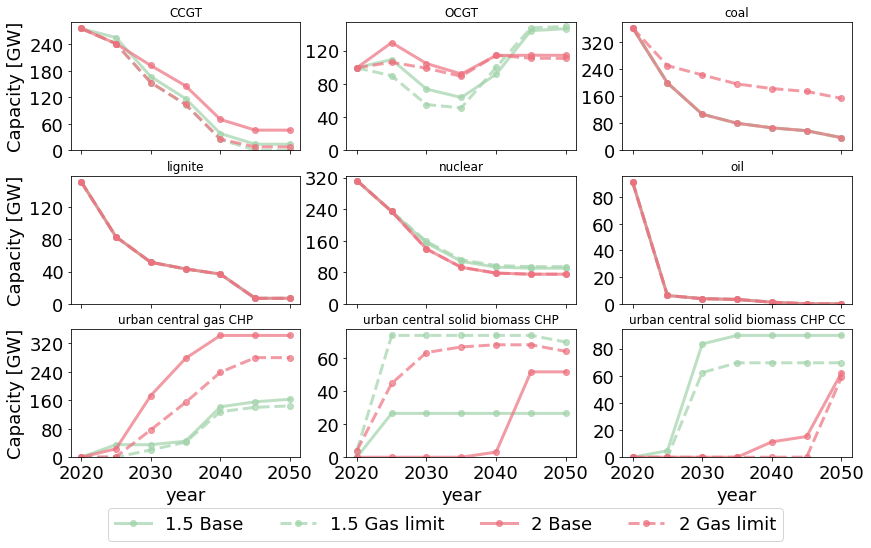

In [22]:
fig,axes = plt.subplots(3,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[6].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0.7, -0.4),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/generator_capacites_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',bbox_inches='tight')

### Other tech capacities

In [23]:
other_techs = ['BEV charger',
                'DAC',
                'Fischer-Tropsch',
                'H2 Electrolysis',
                'H2 Fuel Cell',
                'SMR',
                'SMR CC',
                'Sabatier',
                #'V2G',
                'battery charger',
                #'battery discharger',
                #'helmeth',
                #'home battery charger',
                #'home battery discharger',
                #'biogas to gas',
                #'gas for industry',
                #'gas for industry CC',
                #'solid biomass for industry',
                #'solid biomass for industry CC'
                ]
df = nodal_capacities.loc[('links',slice(None),other_techs)]

df= df.groupby(level=2).sum() * 1e-3

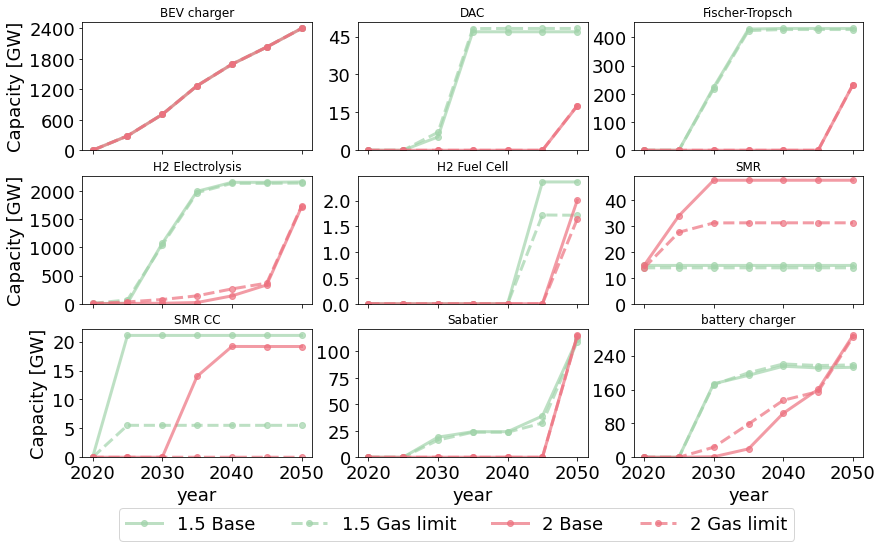

In [24]:
fig,axes = plt.subplots(3,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[6].set_ylabel('Capacity [GW]')
#axes[9].set_ylabel('Capacity [GW]')
#axes[12].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0.7, -0.4),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/other_capacites_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',bbox_inches='tight')

### Storage capacities 

In [25]:
store_techs = ['battery',
                'H2',
                #'Li ion'
                #'residential rural water tanks',
                #'services rural water tanks', 
                'urban central water tanks',
                #'residential urban decentral water tanks',
                #'services urban decentral water tanks'
                ]
df = nodal_capacities.loc[('stores',slice(None),store_techs)]
df.rename({'urban central water tanks':'thermal water tanks'},inplace=True)

df= df.groupby(level=2).sum() * 1e-3

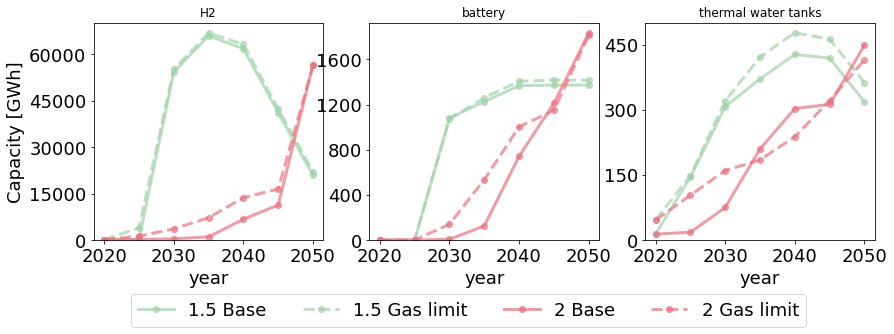

In [26]:
fig,axes = plt.subplots(1,3,figsize=(14,4),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GWh]')
#axes[3].set_ylabel('Capacity [GW]')
#axes[6].set_ylabel('Capacity [GW]')
#axes[9].set_ylabel('Capacity [GW]')
#axes[12].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0.7, -0.25),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/storage_capacites_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',bbox_inches='tight')

In [27]:
gas_techs = ['H2 Electrolysis1',
            'biogas to gas1',
            'Sabatier1',
            'SMR1',
            'Fischer-Tropsch1',
            'SMR CC1',
            #'helmeth1',
            ]


df = supply_energy.loc[(slice(None),'links',gas_techs)]
df.index = df.index.get_level_values(2)
df.index = [i[:-1] for i in df.index]
df = df *1e-6

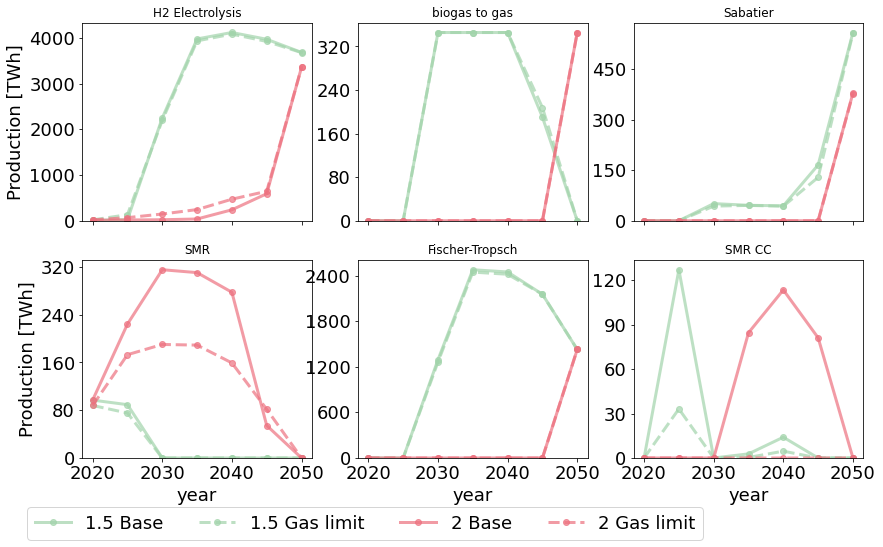

In [28]:
fig,axes = plt.subplots(2,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Production [TWh]')
axes[3].set_ylabel('Production [TWh]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0.3, -0.25),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/syngas_production_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',bbox_inches='tight')

# Heating capacities

In [29]:
heating_techs = ['residential rural biomass boiler', 
                'residential rural gas boiler',
                'residential rural ground heat pump',
                'residential rural resistive heater',
                'residential rural water tanks charger',
                'residential rural water tanks discharger',
                'residential urban decentral air heat pump',
                'residential urban decentral gas boiler',
                'residential urban decentral resistive heater',
                'services rural gas boiler', 
                'services rural ground heat pump',
                'services rural resistive heater', 
                'services rural water tanks charger',
                'services rural water tanks discharger',
                'services urban decentral air heat pump',
                'services urban decentral gas boiler',
                'services urban decentral resistive heater',
                'residential rural oil boiler',
                'residential urban decentral oil boiler', 
                'services rural oil boiler',
                'services urban decentral oil boiler', 
                'urban central oil boiler',
                            ]
df = nodal_capacities.loc[('links',slice(None),heating_techs)]
df= df.groupby(level=2).sum() * 1e-3

df = df.groupby({'residential rural biomass boiler':'biomass boiler', 
                'residential rural gas boiler':'gas boiler',
                'residential rural ground heat pump':'ground heat pump',
                'residential rural resistive heater':'resistive heater',                
                'residential urban decentral air heat pump':'air heat pump',
                'residential urban decentral gas boiler':'gas boiler',
                'residential urban decentral resistive heater':'resistive heater',
                'services rural gas boiler':'gas boiler', 
                'services rural ground heat pump':'ground heat pump',
                'services rural resistive heater':'resistive heater', 
                'services urban decentral air heat pump':'air heat pump',
                'services urban decentral gas boiler':'gas boiler',
                'services urban decentral resistive heater':'resistive heater',
                'residential rural oil boiler':'oil boiler',
                'residential urban decentral oil boiler':'oil boiler', 
                'services rural oil boiler':'oil boiler',
                'services urban decentral oil boiler':'oil boiler', 
                'urban central oil boiler':'oil boiler'}).sum()
df

opt                 1.5_base                                                  \
planning_horizon        2020        2025        2030        2035        2040   
air heat pump      29.735115   27.914182  107.922414  107.796677  102.736510   
biomass boiler     18.116960   14.342584   10.568217    6.793854    0.000001   
gas boiler        884.977520  781.662636  626.432852  471.234342  258.321792   
ground heat pump    6.379190   14.334900   49.383269   50.009065   55.518603   
oil boiler        401.135201  327.967543  244.393783  160.820023   18.730984   
resistive heater  395.335716  351.581762  318.554760  268.119462  318.463602   

opt                                               2_base              \
planning_horizon          2045          2050        2020        2025   
air heat pump     9.255067e+01  3.929845e+01   29.735112   18.241667   
biomass boiler    2.098432e-07  1.248617e-07   18.116964   14.342603   
gas boiler        1.627953e+02  1.324485e+02  884.977444  805.827552   
ground heat pump  5.436403e+01  4.860338e+01    6.379172    6.019229   
oil boiler        0.000000e+00  0.000000e+00  401.135201  327.967543   
resistive heater  2.980137e+02  2.948027e+02  395.335857  351.869992   

opt                           ...    1.5_no_gas                              \
planning_horizon        2030  ...          2040          2045          2050   
air heat pump      12.532310  ...  9.755841e+01  8.474390e+01  3.619360e+01   
biomass boiler     10.568220  ...  8.789494e-07  6.401263e-08  1.529677e-07   
gas boiler        702.583380  ...  2.460036e+02  1.722379e+02  1.541552e+02   
ground heat pump    7.782137  ...  5.694333e+01  5.108132e+01  4.471806e+01   
oil boiler        244.393783  ...  1.873098e+01  0.000000e+00  0.000000e+00   
resistive heater  337.738599  ...  3.315997e+02  3.092286e+02  2.909216e+02   

opt                 2_no_gas                                                  \
planning_horizon        2020        2025        2030        2035        2040   
air heat pump      42.173719   36.343887   33.679236   29.445313   20.892097   
biomass boiler     18.116958   14.342604   10.568223    6.793856    0.000005   
gas boiler        858.143153  744.411473  635.792850  529.645992  486.311930   
ground heat pump   15.770585   19.109419   20.255234   23.763054   30.126359   
oil boiler        401.135201  327.967543  244.393783  160.820023   18.730984   
resistive heater  387.051033  360.174345  340.142768  323.022553  311.115922   

opt                                       
planning_horizon        2045        2050  
air heat pump      17.712660   42.054621  
biomass boiler      0.000007    0.000002  
gas boiler        418.734639  377.245606  
ground heat pump   26.953734   39.877361  
oil boiler          0.000000    0.000000  
resistive heater  265.275376  208.686495  

[6 rows x 28 columns]

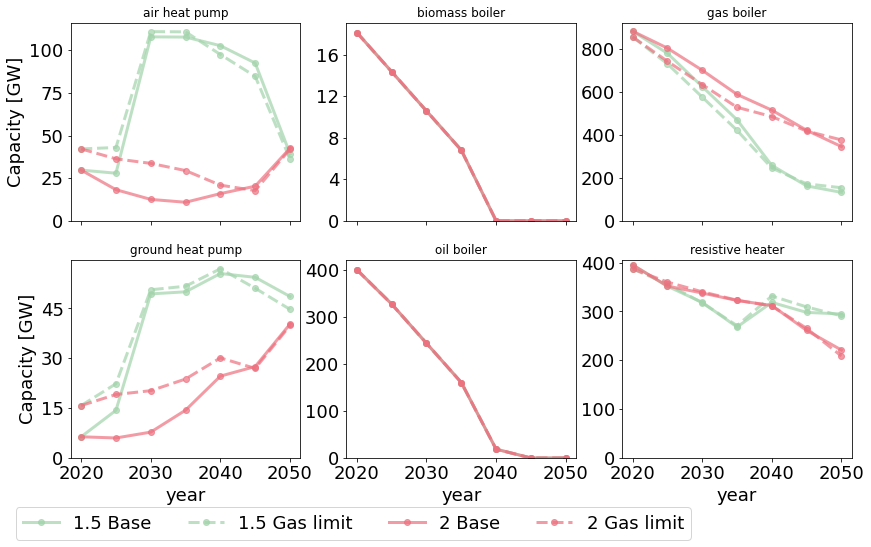

In [32]:
fig,axes = plt.subplots(2,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
#axes[6].set_ylabel('Capacity [GW]')
#axes[9].set_ylabel('Capacity [GW]')
#axes[12].set_ylabel('Capacity [GW]')
#axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.3),borderaxespad=0)
axes[-1].legend(ncol=4,bbox_to_anchor=(0.3, -0.25),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/heating_capacites_pypsaeursec060.pdf',bbox_inches='tight')

## Primary energy plot

In [29]:
def make_primary_energy_df():
    co2_carriers = ["co2", "co2 stored", "process emissions"]
    v = [i for i in supply_energy.index.levels[0] if i not in co2_carriers]

    df = supply_energy.loc[(v,['generators','storage_units','stores'],slice(None))]
    df = df.loc[df.max(axis=1)>1e-2]
    df = df.groupby(level=2).sum() * 1e-6
    df = df.groupby(df.index.map(rename_techs)).sum()

    df_hp = supply_energy.loc[supply_energy.index.get_level_values(2).str.contains('heat pump')]
    df_hp.index = [i[:-1] if ((i != "co2") and (i[-1:] in ["0","1","2","3"])) else i for i in df_hp.index.get_level_values(2)]
    df_hp = df_hp.groupby(df_hp.index).sum() * 1e-6

    df = df.append(df_hp)
    tech_names = {'gas':'gas','air heat pump':'ambient heat', 'biogas':'biomass', 'coal':'coal', 'ground heat pump':'ambient heat',
                        'hydroelectricity':'hydro','hydro':'hydro', 'lignite':'lignite', 'offshore wind (AC)':'wind','offwind':'wind','onwind':'wind','offshore wind':'wind',
                        'offshore wind (DC)':'wind', 'oil':'oil', 'onshore wind':'wind', 'solar PV':'solar',
                        'solar rooftop':'solar', 'solar thermal':'solar', 'solid biomass':'biomass', 'uranium':'uranium','nuclear':'nuclear',
                        'residential rural ground heat pump':'ambient heat',
                        'residential urban decentral air heat pump':'ambient heat',
                        'services rural ground heat pump':'ambient heat',
                        'services urban decentral air heat pump':'ambient heat',
                        'urban central air heat pump':'ambient heat','LNG':'LNG'
       }

    df = df.groupby([tech_names[t] for t in df.index]).sum()

    return df


In [30]:
def plot_energy(scen,ax,df=None,desired_order_list=None,ylabel='Primary energy [TWh]'):
    if df is None:
        #df = make_primary_energy_df()
        df = make_historic_primary_energy()
    if desired_order_list is None:
        desired_order_list = ['gas','coal','lignite','oil' , 'hydro', 'wind'  , 'solar', 'biomass', 'uranium','ambient heat']
        if lngopt == '-LNG':
            desired_order_list += ['LNG']

    #df = df.loc[:,df.columns.get_level_values(1)!='2020']

    title_scen = {'1.5_base':'Baseline','1.5_no_gas':'Gas limit','2_base':'Baseline','2_no_gas':'Gas limit'}
    df_dict = df[scen].T.to_dict(orient='list')
    df_dict = {k: df_dict[k] for k in desired_order_list}
    #ax.stackplot(df[scen].columns,df_dict.values(),labels=df_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()],step='mid');

    df.loc[desired_order_list,scen].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    
    #ax.set_title(title_scen[scen],fontsize=fs,fontweight='bold')
    ax.set_ylabel(rf"$\bf{title_scen[scen]}$" + '\n' + ylabel)

In [31]:
def make_historic_primary_energy():
    df_historic  = pd.read_excel('../data/EU, NO, UK primary energy source in 2019 (kTOE).xlsx',index_col=0).loc['EU + NO + UK']
    df_historic.rename({'heat pump':'ambient heat','geothermal':'other renewables and biofuels','non-renewable waste':'other renewables and biofuels','electricity':'other renewables and biofuels','uranium':'nuclear'},inplace=True)
    kToe_to_TWh = 1.163E-2
    df_historic = df_historic.groupby(level=0).sum()*kToe_to_TWh
    df_historic = df_historic.to_frame(name=('1.5_base','2020'))
    df_historic[('2_base','2020')] = df_historic[('1.5_base','2020')]
    df_historic[('2_no_gas','2020')] = df_historic[('1.5_base','2020')]
    df_historic[('1.5_no_gas','2020')] = df_historic[('1.5_base','2020')]

    df = make_primary_energy_df()
    df.rename({'offshore wind':'wind','onshore wind':'wind'},inplace=True)
    df = df.groupby(level=0).sum()
    df = df.loc[:,df.columns.get_level_values(1)!='2020']
    df = pd.concat((df_historic,df),axis=1)
    return df 


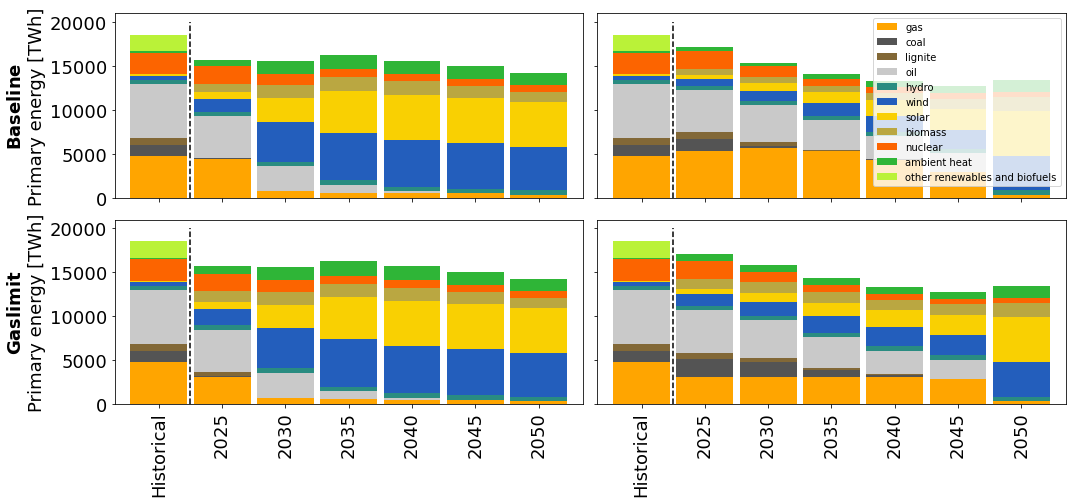

In [32]:
fig,ax = plt.subplots(2,2,figsize=(15,7),sharex=True,sharey=True)
desired_order_list=['gas','coal','lignite','oil', 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat','other renewables and biofuels']

if lngopt == '-LNG':
    desired_order_list += ['LNG']
    
ax = ax.flatten()

scenarios = ['1.5_base','2_base','1.5_no_gas','2_no_gas']

for ax_i,scen in zip(ax,scenarios):
    plot_energy(scen, ax=ax_i,desired_order_list=desired_order_list)

ax[1].legend(loc='upper right') # Not needed when we merge with the other figure
#ax[0].set_ylabel('Primary energy [TWh]')
#ax[2].set_ylabel('Primary energy [TWh]')

labels = [item.get_text() for item in ax[3].get_xticklabels()]
labels[0] = 'Historical'
#labels[1] = ''
ax[3].set_xticklabels(labels)

ax[0].vlines(0.5,0,20000,color='black',linestyle='--')
ax[1].vlines(0.5,0,20000,color='black',linestyle='--')
ax[2].vlines(0.5,0,20000,color='black',linestyle='--')
ax[3].vlines(0.5,0,20000,color='black',linestyle='--')

plt.tight_layout()
#plt.savefig('../figures/Primary_energy_grid.jpeg',dpi=1000,bbox_inches='tight')

# Build rate in terms of energy

In [33]:
df = make_historic_primary_energy()
df.sort_index(axis=1,level=0,inplace=True)
df_diff = (df.diff(axis=1)/df.sum(axis=0))*100
df_diff.drop('2020',axis=1,level=1,inplace=True)
df_diff = df_diff/5


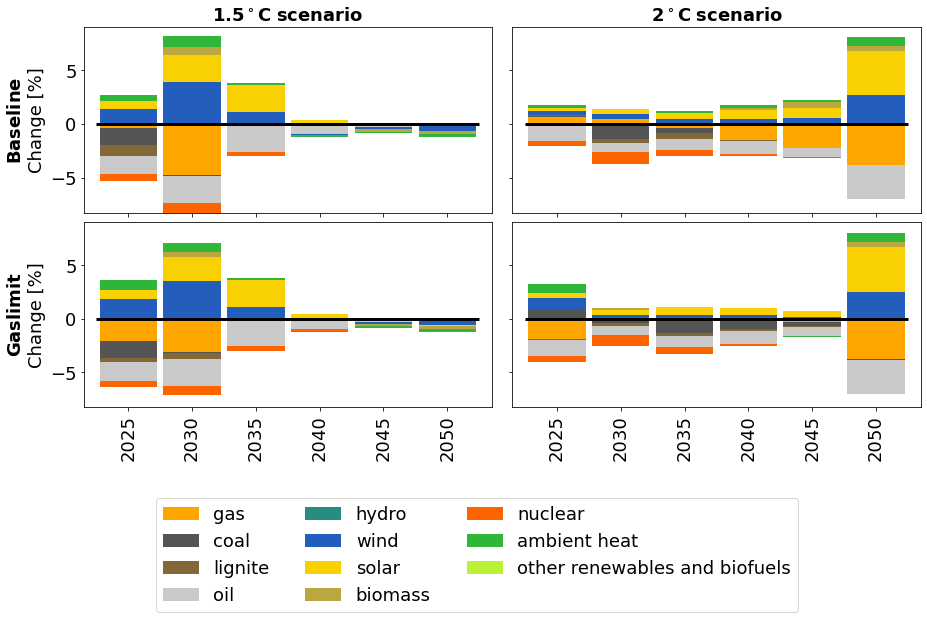

In [34]:
fig,ax = plt.subplots(2,2,figsize=(15,7),sharex=True,sharey=True)
desired_order_list=['gas','coal','lignite','oil', 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat','other renewables and biofuels']
if lngopt == '-LNG':
    desired_order_list += ['LNG']
    
ax = ax.flatten()

scenarios = ['1.5_base','2_base','1.5_no_gas','2_no_gas']

for ax_i,scen in zip(ax,scenarios):
    plot_energy(scen, ax=ax_i,desired_order_list=desired_order_list,df=df_diff,ylabel='Change [%]')

ax[1].legend(loc='upper right') # Not needed when we merge with the other figure
#ax[0].set_ylabel('Primary energy [TWh]')
#ax[2].set_ylabel('Primary energy [TWh]')

labels = [item.get_text() for item in ax[3].get_xticklabels()]
#labels[0] = 'Historical'
#labels[1] = ''
ax[3].set_xticklabels(labels)

for ax_i in ax:
    ax_i.hlines(0,-0.5,5.5,color='black',linestyle='-',linewidth=3)

ax[0].set_title(r"$\bf{1.5^\circ C \; scenario}$",fontweight="bold",fontsize=fs)
ax[1].set_title(r"$\bf{2^\circ C \; scenario}$",fontweight="bold",fontsize=fs)

fig.subplots_adjust(wspace=0.05,hspace=0.05)
ax[1].legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.7, -1.54),borderaxespad=0)

plt.tight_layout()
plt.savefig('../figures/energy_change_paypsaeursec060_oil_lignite_nonextendable' + lngopt + '.jpeg',dpi=1000,bbox_inches='tight')

## Gas figure

### Gas price import

In [35]:
df_gas_price = pd.read_excel('../data/nrg_pc_203__custom_2554243_page_spreadsheet.xlsx',
                            header=11,
                            sheet_name='Sheet 1',
                            index_col=0,
                            usecols= lambda c:True if c[:2] =='20' or c[:2] == 'TI' else False )

gas_price = df_gas_price.loc[['European Union - 27 countries (from 2020)']].T  * 1e3
gas_price.index = gas_price.index.map(lambda i: int(i[:4]) + 0.5 if i[-2:] == 'S2' else  int(i[:4]))
gas_price.rename(columns={'European Union - 27 countries (from 2020)':'Historic'},inplace=True)

### El price import

In [36]:
df_el_price = pd.read_excel('../data/nrg_pc_205__custom_2554284_page_spreadsheet.xlsx',
                            header=11,
                            sheet_name='Sheet 1',
                            index_col=0,
                            usecols= lambda c:True if c[:2] =='20' or c[:2] == 'TI' else False )

el_price = df_el_price.loc[['European Union - 27 countries (from 2020)']].T  * 1e3
el_price.index = el_price.index.map(lambda i: int(i[:4]) + 0.5 if i[-2:] == 'S2' else  int(i[:4]))
el_price.rename(columns={'European Union - 27 countries (from 2020)':'Historic'},inplace=True)
el_price = el_price[2010:]

### CO2 price import

In [37]:
def to_integer(dt_time):
    dt_time = pd.to_datetime(dt_time)
    return 1*dt_time.year + 1/12*(dt_time.month-1)  + 1/365*(dt_time.day-1)

<AxesSubplot:xlabel='Date'>

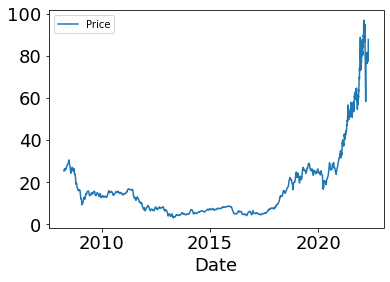

In [38]:
co2_price = pd.read_csv('../data/EMBER_Coal2Clean_EUETSPrices.csv',index_col=0)
co2_price.index = co2_price.index.map(to_integer)
co2_price.plot()

In [39]:
df = metrics.loc['co2_shadow'].unstack(level=0)
df.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)
df.columns.name = 'scenario'

In [40]:
df = gas_prices.pivot(index='year',columns='scenario') + 20.1
df.columns = df.columns.get_level_values(1)
df.rename(columns={'1.5':'1.5 Gas limit','2':'2 Gas limit'},inplace=True)
df['1.5 Base'] = 20.1
df['2 Base'] = 20.1
df


scenario,1.5 Gas limit,2 Gas limit,1.5 Base,2 Base
year,,,,
2020,55.358905,55.358933,20.1,20.1
2025,66.987140,86.208486,20.1,20.1
2030,20.100001,82.774219,20.1,20.1
2035,20.100000,50.520736,20.1,20.1
2040,20.100000,44.095029,20.1,20.1
2045,20.100000,20.100009,20.1,20.1
2050,20.100000,20.100000,20.1,20.1


In [41]:
df = gas_prices.pivot(index='year',columns='scenario').iloc[1:,:] + 20.1
df.columns = df.columns.get_level_values(1)
df.rename(columns={'1.5':'1.5 Gas limit','2':'2 Gas limit'},inplace=True)
df['1.5 Base'] = 20.1
df['2 Base'] = 20.1
df.index = df.index.astype(int)

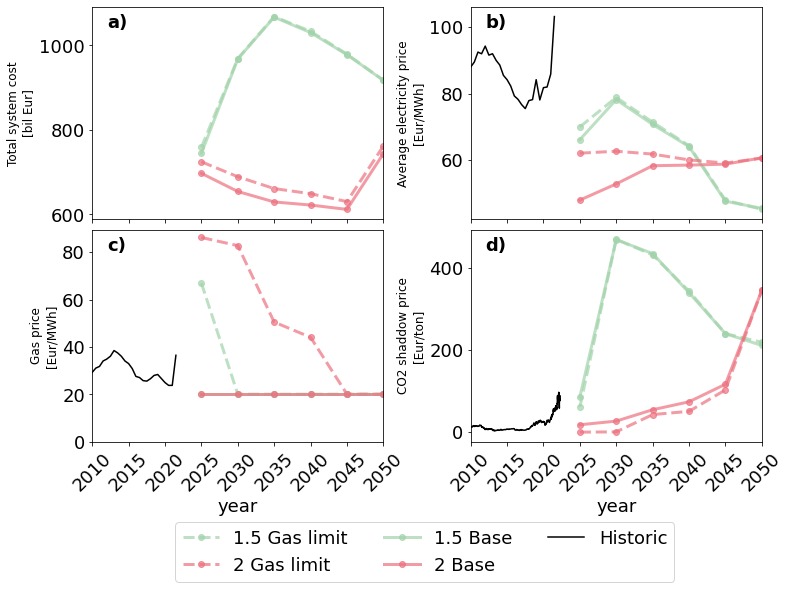

In [42]:
rc('text', usetex=False)
fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True)
ax = ax.flatten()

# Co2 price
df = metrics.loc['co2_shadow'].unstack(level=0).iloc[1:,:]
df.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)
df.columns.name = 'scenario'
df.index = df.index.astype(int)
df.plot(ax=ax[3],
        style=['-','--','-','--'],
        color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
co2_price.plot(ax=ax[3],color='black',legend=False)        
ax[3].set_ylabel('CO2 shaddow price\n[Eur/ton]',fontsize=12)
#ax[3].legend(loc='upper left')

# Total system cost
df = metrics.loc['total costs']*1e-9
df = df.unstack(level=0).iloc[1:,:]
df.rename(columns={'1.5_base':'1.5 Basline','1.5_no_gas':'1.5 Gas limit','2_no_gas':'2 Gas limit','2_base':'2 Baseline'},inplace=True)
df.index = df.index.astype(int)
df.plot(ax=ax[0],
        style=['-','--','-','--'],
        color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[0].set_ylabel('Total system cost\n[bil Eur]',fontsize=12)

# Gas price
df = gas_prices.pivot(index='year',columns='scenario').iloc[1:,:] + 20.1
df.columns = df.columns.get_level_values(1)
df.rename(columns={'1.5':'1.5 Gas limit','2':'2 Gas limit'},inplace=True)
df['1.5 Base'] = 20.1
df['2 Base'] = 20.1
df.index = df.index.astype(int)
df.plot(ax=ax[2],
        style=['--','--'],
        color=['#A2D4AB','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
gas_price.plot(ax=ax[2],color='black',label='Historical')
ax[2].set_ylabel('Gas price\n[Eur/MWh]',fontsize=12)
start, end = ax[2].get_ylim()
ax[2].set_ylim((0, end))

# El price
df = prices.loc['mean'].unstack(level=0).iloc[1:,:]
df.index = df.index.astype(int)
df.plot(ax=ax[1],style=['-','--','-','--'],color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F','c'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
el_price.plot(ax=ax[1],color='black',legend=False)
ax[1].set_ylabel('Average electricity price\n[Eur/MWh]',fontsize=12)


ax[2].xaxis.set_ticks(np.arange(2010, 2055, 5))
ax[2].set_xlim(2010,2050)
ax[2].tick_params(axis='x', labelrotation = 45)
ax[3].tick_params(axis='x', labelrotation = 45)
ax[2].set_xlabel('year')
ax[3].set_xlabel('year')

#ax[0].annotate('test',xy=(2030,860),xytext=(2030,750),xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05))
#ax[3].xaxis.set_ticks(np.arange(-1, 4, 5))

plt.subplots_adjust(wspace=0.3,hspace=0.05)


for ax_i,t in zip(ax,['a)','b)','c)','d)',]):
    ax_i.text(0.05,0.9,t,transform = ax_i.transAxes,fontweight="bold",fontsize=fs)

ax[2].legend(ncol=3,bbox_to_anchor=(2, -0.38),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/prices_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',bbox_inches='tight')

## Ebbes Figure

In [43]:
tech_names = {'gas':'gas','air heat pump':'ambient heat', 'biogas':'biogas', 'coal':'coal', 'ground heat pump':'ambient heat',
                        'hydroelectricity':'hydro', 'lignite':'lignite', 'offshore wind (AC)':'offshore wind',
                        'offshore wind (DC)':'offshore wind', 'oil':'oil', 'onshore wind':'onshore wind', 'solar PV':'solar',
                        'solar rooftop':'solar', 'solar thermal':'solar', 'solid biomass':'biomass', 'uranium':'uranium'}

In [44]:
scen = '2'
df = make_primary_energy_df()

diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
diff.iloc[diff.values<0] = 0
diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

diff_dict['gas'] = list(supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6)

desired_order_list = ['gas','coal','lignite','oil' , 'hydro',  'wind',  'solar', 'biomass', 'nuclear','ambient heat']
if lngopt == '-LNG':
    desired_order_list += ['LNG']
    
diff_dict = {k: diff_dict[k] for k in desired_order_list}

In [45]:
def plot_ebbes3(scen,ax):
    df = make_primary_energy_df()
    df = df.loc[:,df.columns.get_level_values(1)!='2020']


    diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
    diff.iloc[diff.values<0] = 0


    diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

    diff_dict['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values[1:] *1e-6
    diff.loc['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values[1:] *1e-6



    desired_order_list = ['gas','ambient heat' , 'wind', 'solar', 'biomass','oil','coal','lignite']
    if lngopt == '-LNG':
        desired_order_list += ['LNG']
    
    diff_dict = {k: diff_dict[k] for k in desired_order_list}

    df_base = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum()[1:] * 1e-6
    ax.plot([0,1,2,3,4,5],df_base.values,label=None,linewidth=5,color='black',)

    #df_base.plot(ax=ax,label='Gas use (unlimited)',linewidth=5,color='black',drawstyle='steps-mid')
    df_no_gas = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum()[1:] * 1e-6
    #ax.plot([0,1,2,3,4,5],df_no_gas.values,label='Gas use (unlimited)',linewidth=5,color='black',linestyle='--',)
    ax.plot([-0.5,1,2,3,4,5,6.5],[3100]*7,label=None,linewidth=3,color='black',linestyle='--',drawstyle='steps-mid')

    #df_no_gas.plot(ax=ax,label='Gas use (limited)',linewidth=5,color='black',linestyle='--',drawstyle='steps-mid')

    #diff.loc[desired_order_list].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    

    ax.stackplot(list(diff.columns),diff_dict.values(),labels=diff_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()])
    #ax.fill_between(list(diff.columns),np.sum(list(diff_dict.values()),axis=0),supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum() * 1e-6,hatch='//',color='white',edgecolor='black',label='Efficiency improvements')
    #ax.legend(loc='upper right')
    scen_title = {'1.5':'1.5C gas substitution','2':'2C gas substitution'}
    #ax.set_title(scen_title[scen],fontweight="bold",fontsize=fs)
    ax.set_xlabel('Year')
    ax.set_ylabel('Primary energy [TWh]')
    ax.set_xticks(np.arange(7))
    #ax.legend(loc='upper right')

In [46]:
def plot_ebbes2(scen,ax):
    df = make_primary_energy_df()
    #df.loc[:,df.columns.get_level_values(1)=='2020'] = 0


    diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
    diff.iloc[diff.values<0] = 0
    diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

    diff_dict['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6
    diff.loc['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6

    diff['2020'] = 0


    desired_order_list = ['gas','coal','lignite','oil' , 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat']
    if lngopt == '-LNG':
        desired_order_list += ['LNG']
    
    diff_dict = {k: diff_dict[k] for k in desired_order_list}

    df_base = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum()[1:] * 1e-6
    ax.plot([0.5,1,2,3,4,5,6,6.5],df_base.values[[0,0,1,2,3,4,5,5]],label='Gas use (unlimited)',linewidth=3,color='black',drawstyle='steps-mid')

    #df_base.plot(ax=ax,label='Gas use (unlimited)',linewidth=5,color='black',drawstyle='steps-mid')
    df_no_gas = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum()[1:] * 1e-6
    ax.plot([-0.5,1,2,3,4,5,6.5],[3100]*7,label='Gas use (unlimited)',linewidth=3,color='black',linestyle='--',drawstyle='steps-mid')
    #df_no_gas.plot(ax=ax,label='Gas use (limited)',linewidth=5,color='black',linestyle='--',drawstyle='steps-mid')

    diff.loc[desired_order_list].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    

    #ax.stackplot(list(diff.columns),diff_dict.values(),labels=diff_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()],step='mid')
    #ax.fill_between(list(diff.columns),np.sum(list(diff_dict.values()),axis=0),supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum() * 1e-6,hatch='//',color='white',edgecolor='black',label='Efficiency improvements')
    #ax.legend(loc='upper right')
    scen_title = {'1.5':'1.5C gas substitution','2':'2C gas substitution'}
    #ax.set_title(scen_title[scen],fontweight="bold",fontsize=fs)
    ax.set_xlabel('Year')
    ax.set_ylabel(r"$\bf{Difference}$" + '\nPrimary energy [TWh]')
    ax.set_xticks(np.arange(7))
    #ax.legend(loc='upper right')

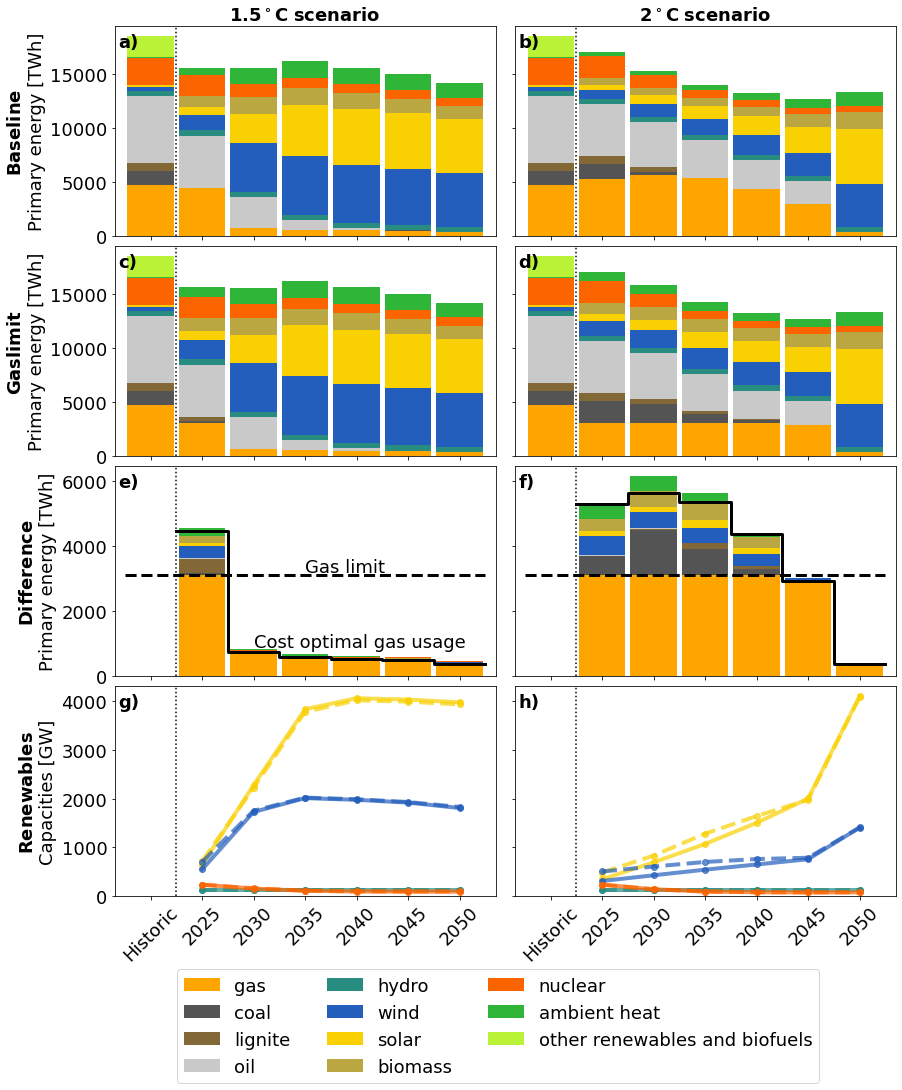

In [47]:
# Combined 
fig,ax = plt.subplots(4,2,figsize=(14,16),sharey='row',sharex=True)
ax = ax.flatten()
desired_order_list=['gas','coal','lignite','oil', 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat','other renewables and biofuels']

if lngopt == '-LNG':
    desired_order_list += ['LNG']
    
scenarios = ['1.5_base','2_base','1.5_no_gas','2_no_gas']
for ax_i,scen in zip(ax[:4],scenarios):
    plot_energy(scen, ax=ax_i,
                desired_order_list=desired_order_list)

scenarios = ['1.5','2']
for ax_i,scen in zip(ax[[4,5]],scenarios):
    plot_ebbes2(scen,ax_i)

df = gen_df_for_cap_plot(lngopt)
#df = df.loc[:,df.columns.get_level_values(1)!='2020']
for i,scen in enumerate(['1.5','2']):
    df_i = df.loc[:,[f'{scen}_base',f'{scen}_no_gas']].T.unstack(level=0)
    df_i.loc['2020'] = np.nan

    #df_i.index = df_i.index.astype(int)
    
    df_i.plot(color=[tech_colors[t] for t in list(df_i.columns.get_level_values(0))],
                style=['-','--']*10,
                marker='o',
                alpha=0.7,
                ax=ax[i+6],
                linewidth=4,
                legend=False,
                label='test',
                #drawstyle='steps-mid'
                )
    ax[i+6].set_ylabel(r"$\bf{Renewables}$"+'\nCapacities [GW]')
    ax[i+6].set_xlabel('Year')
    #ax[i+6].set_title(f'{scen}C Renewable capacities',fontweight="bold",fontsize=fs)
    #ax[i+6].xaxis.set_major_locator(plt.MaxNLocator(7))

for ax_i in ax:
    start,end = ax_i.get_ylim()
    start = 0
    ax_i.set_ylim(start,end)
    ax_i.vlines(0.5,start,end,color='black',linestyle=':')

labels = [item.get_text() for item in ax[7].get_xticklabels()]
labels[0] = 'Historic'
ax[7].set_xticklabels(labels)
ax[7].set_xlabel('')
ax[6].set_xlabel('')
ax[6].tick_params(axis='x', labelrotation = 45)
ax[7].tick_params(axis='x', labelrotation = 45)

ax[0].set_title(r"$\bf{1.5^\circ C \; scenario}$",fontweight="bold",fontsize=fs)
ax[1].set_title(r"$\bf{2^\circ C \; scenario}$",fontweight="bold",fontsize=fs)

ax[4].annotate('Gas limit',xy=(3,3200),fontsize=fs)
ax[4].annotate('Cost optimal gas usage',xy=(2,900),fontsize=fs)

fig.subplots_adjust(wspace=0.05,hspace=0.05)
ax[3].legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.8, -2.45),borderaxespad=0)

#ax[6].legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.8, -2.45),borderaxespad=0)

for ax_i,t in zip(ax,['a)','b)','c)','d)','e)','f)','g)','h)']):
    ax_i.text(0.01,0.9,t,transform = ax_i.transAxes,fontweight="bold",fontsize=fs)

plt.savefig(f'../figures/primary_energy_grid2_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',dpi=500,bbox_inches='tight')

## Graphical abstract plot

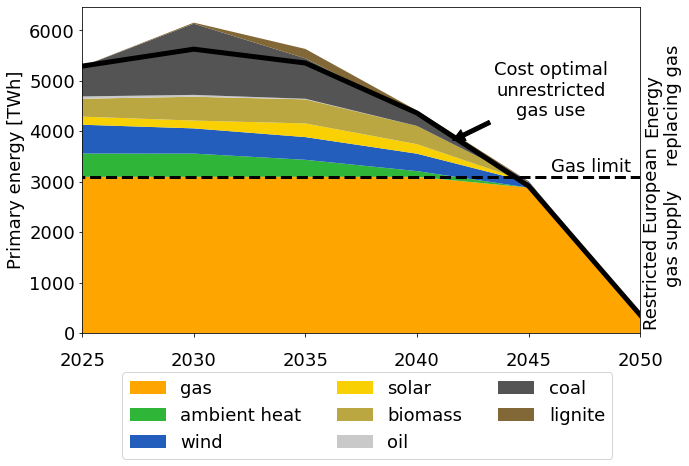

In [48]:
# Graphical abstract
scen = '2'
fig,ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
#for ax_i,scen in zip(ax,scenarios):
plot_ebbes3(scen,ax)

fig.subplots_adjust(wspace=0.05)
ax.legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.95, -0.12),borderaxespad=0)

ax.set_xlim([0,5])
ax.tick_params(axis='x', which='major', pad=15)
ax.set_xlabel('')

ax.text(5.2,150,
        'Restricted European\ngas supply',
        fontsize=fs,
        rotation=90,
        horizontalalignment='center',)
ax.text(4.2,3200,'Gas limit',fontsize=fs)
ax.annotate('Energy\nreplacing gas',
            xy=(2.8,3700),
            xytext=(5.2,3400),
            fontsize=fs,
            horizontalalignment='center',
            rotation=90,
            #arrowprops=dict(facecolor='black', shrink=0.05)
            )
#ax.annotate('Lower efficiency',
#            xy=(2,5000),
#            xytext=(3.2,5000),
#            fontsize=fs,
#            horizontalalignment='center',
#            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Cost optimal\nunrestricted\ngas use',
            xy=(3.3,3800),
            xytext=(4.2,4300),
            fontsize=fs,
            horizontalalignment='center',
            arrowprops=dict(facecolor='black', shrink=0.05))


plt.savefig(f'../figures/GraphAbstract_pypsaeursec060_oil_lignite_nonextendable' + lngopt + '.pdf',dpi=500,bbox_inches='tight')